In [38]:
import h5py
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import time
import glob

import torch
print(torch.__version__)
print(torch.version.cuda)

import sys
print("Python version")
print(sys.version)

import torchvision
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

1.11.0
11.3
Python version
3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]


In [142]:
!pip install torchsummary

In [2]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, path_to_images, sens_name, sens_classes, transform):
        super(BaseDataset, self).__init__()
        
        self.dataframe = dataframe        
        self.dataset_size = self.dataframe.shape[0]
        self.transform = transform
        self.path_to_images = path_to_images
        self.sens_name = sens_name
        self.sens_classes = sens_classes
        
        self.A = None
        self.Y = None
        self.AY_proportion = None
        
    def get_AY_proportions(self):
        if self.AY_proportion:
            return self.AY_proportion
        
        A_num_class = 2
        Y_num_class = 2
        A_label = self.A
        Y_label = self.Y
        
        A = self.A.tolist()
        Y = self.Y.tolist()
        ttl = len(A)
            
        len_A0Y0 = len([ay for ay in zip(A, Y) if ay == (0, 0)])
        len_A0Y1 = len([ay for ay in zip(A, Y) if ay == (0, 1)])
        len_A1Y0 = len([ay for ay in zip(A, Y) if ay == (1, 0)])
        len_A1Y1 = len([ay for ay in zip(A, Y) if ay == (1, 1)])

        assert (
            len_A0Y0 + len_A0Y1 + len_A1Y0 + len_A1Y1
        ) == ttl, "Problem computing train set AY proportion."
        A0Y0 = len_A0Y0 / ttl
        A0Y1 = len_A0Y1 / ttl
        A1Y0 = len_A1Y0 / ttl
        A1Y1 = len_A1Y1 / ttl
        
        self.AY_proportion = [[A0Y0, A0Y1], [A1Y0, A1Y1]]
        
        return self.AY_proportion
    
    def get_A_proportions(self):
        AY = self.get_AY_proportions()
        ret = [AY[0][0] + AY[0][1], AY[1][0] + AY[1][1]]
        np.testing.assert_almost_equal(np.sum(ret), 1.0)
        return ret

    def get_Y_proportions(self):
        AY = self.get_AY_proportions()
        ret = [AY[0][0] + AY[1][0], AY[0][1] + AY[1][1]]
        np.testing.assert_almost_equal(np.sum(ret), 1.0)
        return ret

    def set_A(self, sens_name):
        if sens_name == 'Sex':
            A = np.asarray(self.dataframe['Sex'].values != 'M').astype('float')
        elif sens_name == 'Age':
            A = np.asarray(self.dataframe['Age_binary'].values.astype('int') == 1).astype('float')
        elif sens_name == 'Race':
            A = np.asarray(self.dataframe['Race'].values == 'White').astype('float')
        elif self.sens_name == 'skin_type':
            A = np.asarray(self.dataframe['skin_binary'].values != 0).astype('float')
        elif self.sens_name == 'Insurance':
            self.A = np.asarray(self.dataframe['Insurance_binary'].values != 0).astype('float')
        else:
            raise ValueError("Does not contain {}".format(self.sens_name))
        return A

    def get_weights(self, resample_which):
        sens_attr, group_num = self.group_counts(resample_which)
        group_weights = [1/x.item() for x in group_num]
        sample_weights = [group_weights[int(i)] for i in sens_attr]
        return sample_weights
    
    def group_counts(self, resample_which = 'group'):
        if resample_which == 'group' or resample_which == 'balanced':
            if self.sens_name == 'Sex':
                mapping = {'M': 0, 'F': 1}
                groups = self.dataframe['Sex'].values
                group_array = [*map(mapping.get, groups)]
                
            elif self.sens_name == 'Age':
                if self.sens_classes == 2:
                    groups = self.dataframe['Age_binary'].values
                elif self.sens_classes == 5:
                    groups = self.dataframe['Age_multi'].values
                elif self.sens_classes == 4:
                    groups = self.dataframe['Age_multi4'].values.astype('int')
                group_array = groups.tolist()
                
            elif self.sens_name == 'Race':
                mapping = {'White': 0, 'non-White': 1}
                groups = self.dataframe['Race'].values
                group_array = [*map(mapping.get, groups)]
            elif self.sens_name == 'skin_type':
                if self.sens_classes == 2:
                    groups = self.dataframe['skin_binary'].values
                elif self.sens_classes == 6:
                    groups = self.dataframe['skin_type'].values
                group_array = groups.tolist()
            elif self.sens_name == 'Insurance':
                if self.sens_classes == 2:
                    groups = self.dataframe['Insurance_binary'].values
                elif self.sens_classes == 5:
                    groups = self.dataframe['Insurance'].values
                group_array = groups.tolist()
            else:
                raise ValueError("sensitive attribute does not defined in BaseDataset")
            
            if resample_which == 'balanced':
                #get class
                labels = self.Y.tolist()
                num_labels = len(set(labels))
                num_groups = len(set(group_array))
                
                group_array = (np.asarray(group_array) * num_labels + np.asarray(labels)).tolist()
                
        elif resample_which == 'class':
            group_array = self.Y.tolist()
            num_labels = len(set(group_array))
        
        self._group_array = torch.LongTensor(group_array)
        if resample_which == 'group':
            self._group_counts = (torch.arange(self.sens_classes).unsqueeze(1)==self._group_array).sum(1).float()
        elif resample_which == 'balanced':
            self._group_counts = (torch.arange(num_labels * num_groups).unsqueeze(1)==self._group_array).sum(1).float()
        elif resample_which == 'class':
            self._group_counts = (torch.arange(num_labels).unsqueeze(1)==self._group_array).sum(1).float()
        return group_array, self._group_counts
    
    def __len__(self):
        return self.dataset_size
    
    def get_labels(self): 
        # for sensitive attribute imbalance
        if self.sens_classes == 2:
            return self.A
        elif self.sens_classes == 5:
            return self.dataframe['Age_multi'].values.tolist()
        elif self.sens_classes == 4:
            return self.dataframe['Age_multi4'].values.tolist()

    def get_sensitive(self, sens_name, sens_classes, item):
        if sens_name == 'Sex':
            if item['Sex'] == 'M':
                sensitive = 0
            else:
                sensitive = 1
        elif sens_name == 'Age':
            if sens_classes == 2:
                sensitive = int(item['Age_binary'])
            elif sens_classes == 5:
                sensitive = int(item['Age_multi'])
            elif sens_classes == 4:
                sensitive = int(item['Age_multi4'])
        elif sens_name == 'Race':
            if item['Race'] == 'White':
                sensitive = 0
            else:
                sensitive = 1
        elif sens_name == 'skin_type':
            if sens_classes == 2:
                sensitive = int(item['skin_binary'])
            else:
                sensitive = int(item['skin_type'])
        elif self.sens_name == 'Insurance':
            if self.sens_classes == 2:
                sensitive = int(item['Insurance_binary'])
            elif self.sens_classes == 5:
                sensitive = int(item['Insurance'])
        else:
            raise ValueError('Please check the sensitive attributes.')
        return sensitive

In [69]:
class COVID_CT_MD(BaseDataset):
    def __init__(self, dataframe, path_to_images, sens_name, sens_classes, transform):
        super(COVID_CT_MD, self).__init__(dataframe, path_to_images, sens_name, sens_classes, transform)
        
        self.A = self.set_A(sens_name)
        self.Y = self.dataframe['binary_label'].to_numpy()
        self.AY_proportion = None
        
    def __getitem__(self, idx):
        item = self.dataframe.iloc[idx]
        img = np.load(os.path.join(self.path_to_images, item["Path"]))
        img = np.expand_dims(img, axis=0)
        img = sc.fit_transform(img.T).T[0]

        label = torch.FloatTensor([item['binary_label']])
        sensitive = self.get_sensitive(self.sens_name, self.sens_classes, item)
        
        return idx, img, label, sensitive

In [70]:
PATH = '/hdd/Dataset/'

In [71]:
df = pd.read_csv(PATH+'split/new_train.csv',index_col=0)
one_hot_label = []
for l in df['binary_label']:
    if l==1:
        one_hot_label.append(np.array([0,1]))
    elif l==0:
        one_hot_label.append(np.array([1,0]))
    else:
        print(l)

df['binary_label'] = one_hot_label
df

,Diagnosis,Folder,Sex,Patient Age,Weight,Clinical characteristics,Surgery,Follow-up,PCR,Path,Age,Age_multi,Age_binary,binary_label
0,COVID-19,P001,M,039Y,80.0,"Dyspnea, Cough, Fever",NaN,NaN,NaN,COVID-19 Cases 3D/P001.npy,39,1,0,"[0, 1]"
1,COVID-19,P002,F,048Y,75.0,"Dyspnea, Flu-like symptoms",No,Uneventful,NaN,COVID-19 Cases 3D/P002.npy,48,2,0,"[0, 1]"
2,COVID-19,P003,M,068Y,90.0,Cough,NaN,Hospitalized,NaN,COVID-19 Cases 3D/P003.npy,68,3,1,"[0, 1]"
3,COVID-19,P004,M,065Y,75.0,"Dyspnea, fever",No,Uneventful,NaN,COVID-19 Cases 3D/P004.npy,65,3,1,"[0, 1]"
4,COVID-19,P005,M,029Y,78.0,"Cough, Fatigue",No,Uneventful,NaN,COVID-19 Cases 3D/P005.npy,29,1,0,"[0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Normal,normal071,F,043Y,82.0,Check-up before uterus surgery,Yes,NaN,NaN,Normal Cases 3D/normal071.npy,43,2,0,"[1, 0]"
303,Normal,normal073,M,039Y,96.0,"Headache, Myalgia",Yes,NaN,NaN,Normal Cases 3D/normal073.npy,39,1,0,"[1, 0]"
304,Normal,normal074,M,040Y,97.0,Chest pain,Yes,NaN,NaN,Normal Cases 3D/normal074.npy,40,2,0,"[1, 0]"
305,Normal,normal075,M,056Y,92.0,Dyspnea,NaN,NaN,NaN,Normal Cases 3D/normal075.npy,56,2,0,"[1, 0]"


In [124]:
df = pd.read_csv(PATH+'split/new_train.csv',index_col=0)
# one_hot_label = []
# for l in df['binary_label']:
#     if l==1:
#         one_hot_label.append(np.array([0,1]))
#     elif l==0:
#         one_hot_label.append(np.array([1,0]))
#     else:
#         print(l)
# df['binary_label'] = one_hot_label
train_data = COVID_CT_MD(df, PATH+'embedding/', sens_name='Sex', sens_classes=2, transform=None)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

df_test = pd.read_csv(PATH+'split/new_test.csv',index_col=0)
# one_hot_label = []
# for l in df_test['binary_label']:
#     if l==1:
#         one_hot_label.append(np.array([0,1]))
#     elif l==0:
#         one_hot_label.append(np.array([1,0]))
#     else:
#         print(l)
# df_test['binary_label'] = one_hot_label
test_data = COVID_CT_MD(df_test, PATH+'embedding/', sens_name='Sex', sens_classes=2, transform=None)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

df_val = pd.read_csv(PATH+'split/new_val.csv',index_col=0)
# one_hot_label = []
# for l in df_val['binary_label']:
#     if l==1:
#         one_hot_label.append(np.array([0,1]))
#     elif l==0:
#         one_hot_label.append(np.array([1,0]))
#     else:
#         print(l)
# df_val['binary_label'] = one_hot_label
val_data = COVID_CT_MD(df_val, PATH+'embedding/', sens_name='Sex', sens_classes=2, transform=None)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=True)

In [244]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 3, stride=3)
        self.conv2 = nn.Conv1d(32, 64, 3, stride=3)
        self.pool = nn.MaxPool1d(3, stride=3)
        self.fc1 = nn.Linear(64*6,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,1)  
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*6)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


net = Classifier().to('cuda:0')
optimizer = torch.optim.Adam(net.parameters(),lr=0.0001,weight_decay=0.0005)
loss_fn = nn.BCELoss()

In [245]:
train_loss = []
loss_val = []

for epoch in range(50):
    running_loss = 0.0 
    val_loss = 0
    net.train()
    for i, (index, images, targets, sensitive_attr) in enumerate(train_loader):
        images, targets, sensitive_attr = images.to('cuda:0'), targets.to('cuda:0'), sensitive_attr.to('cuda:0')
        optimizer.zero_grad()
        outputs = net(images.view(-1, 1, 512))
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    net.eval()
    for i, (index, images, targets, sensitive_attr) in enumerate(val_loader):
        images, targets, sensitive_attr = images.to('cuda:0'), targets.to('cuda:0'), sensitive_attr.to('cuda:0')
        outputs = net(images.view(-1, 1, 512))
        loss = loss_fn(outputs, targets)
        val_loss += loss.item()

    if epoch % 25 == 0:
        print(f'[epoch: {epoch + 1}] train loss: {running_loss:.3f} val loss: {val_loss:.3f}')
        train_loss.append(running_loss)
        loss_val.append(val_loss)
        running_loss, val_loss = 0.0, 0.0


[epoch: 1] train loss: 11.069 val loss: 1.343
[epoch: 26] train loss: 10.465 val loss: 1.329


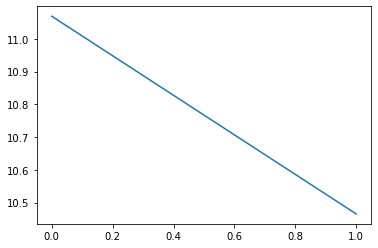

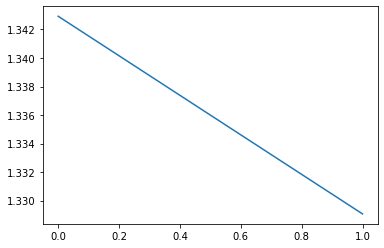

In [246]:
plt.plot(train_loss)
plt.show()
plt.plot(loss_val)
plt.show()

In [247]:
net.eval()
pred_true = 0
total_cases = 0
pred_false = 0
out_p = []
idx_l = []
sex_l = []
lab_l = []
true_case, false_case = 0, 0

for i, (index, images, targets, sensitive_attr) in enumerate(test_loader):
    images, targets, sensitive_attr = images.to('cuda:0'), targets.to('cuda:0'), sensitive_attr.to('cuda:0')
    outputs = net(images.view(-1, 1, 512))
    # out_p.append(outputs.item())
    # idx_l.append(index.item())
    # sex_l.append(sensitive_attr.item())
    # lab_l.append(targets.item())
    print(outputs, targets)
    
    for idx, pred in enumerate(outputs):
        
        
        if pred.item() >= 0.7:
            true_case += 1
        else:
            false_case += 1
            
        if pred.item() >= 0.7 and targets[idx][0].item() == 1:
            pred_true += 1
        elif pred.item() < 0.7 and targets[idx][0].item() == 0:
            pred_true += 1
        else:
            pred_false += 1
    
        total_cases += 1
    loss = F.mse_loss(outputs, targets)
        

tensor([[0.2404],
        [0.7833],
        [0.6117],
        [0.4925],
        [0.6215],
        [0.8414],
        [0.6271],
        [0.8580],
        [0.4066],
        [0.8189],
        [0.8604],
        [0.5686],
        [0.7971],
        [0.7613],
        [0.8546],
        [0.7267]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0')
tensor([[0.7143],
        [0.6586],
        [0.6299],
        [0.6437],
        [0.6689],
        [0.3082],
        [0.6373],
        [0.5454],
        [0.8494],
        [0.4189],
        [0.4420],
        [0.7512],
        [0.6903],
        [0.7749],
        [0.6080]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0

In [248]:
print(pred_true, pred_false)

19 12


In [249]:
true_case, false_case

(13, 18)

In [250]:
print(pred_true/total_cases)

0.6129032258064516


In [ ]:
import numpy as np
from sklearn import metrics
def sub_group_auc(y, pred, pos_label_):
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=pos_label_)
    sub_group_auc = metrics.auc(fpr, tpr)
    return sub_group_auc

In [ ]:
df_output = pd.DataFrame(out_p)

In [ ]:
df_output.columns = ['pred']

ValueError: ignored

In [ ]:
df_output['index'] = idx_l
df_output['sex'] = sex_l
df_output['lable'] = lab_l

In [ ]:
df.Sex.value_counts()

M    147
F     97
Name: Sex, dtype: int64

In [ ]:
df_output.sex.value_counts()

0    147
1     97
Name: sex, dtype: int64

In [ ]:
import numpy as np
from sklearn import metrics
def sub_group_auc(y, pred, pos_label_):
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=pos_label_)
    sub_group_auc = metrics.auc(fpr, tpr)
    return sub_group_auc

In [ ]:
y_F = np.array(df_output.loc[df_output.sex==1].lable)
pred_F = np.array(df_output.loc[df_output.sex==1].pred)
y_M = np.array(df_output.loc[df_output.sex==0].lable)
pred_M = np.array(df_output.loc[df_output.sex==0].pred)

In [ ]:
#baseline group fairness indicator for gender:
sub_group_auc_F = sub_group_auc(y_F, pred_F, 1)
sub_group_auc_M = sub_group_auc(y_M, pred_M, 1)
group_fairness_baseline_gender = sub_group_auc_M - sub_group_auc_F

In [ ]:
group_fairness_baseline_gender

0.14003831417624518

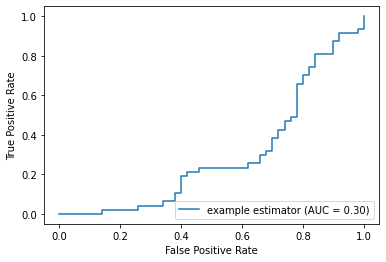

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_F, pred_F)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

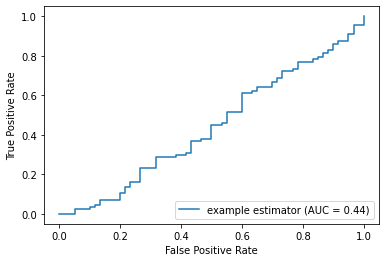

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_M, pred_M)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

In [ ]:
#fairness algorithm group fairness indicator for gender:
#sub_group_auc_fairness_F = sub_group_auc(y_F, pred_fairness_F, 1)
#sub_group_auc_fairness_M = sub_group_auc(y_M, pred_fairness_M, 1)
#group_fairness_fair_algorithm_gender = sub_group_auc_fairness_F - sub_group_auc_fairness_M

In [ ]:
#baseline group fairness indicator for gender:
sub_group_auc_M = sub_group_auc(y_M, pred_M, 1)
maxMin_fairness_baseline_gender = sub_group_auc_M

In [ ]:
#fairness algorithm group fairness indicator for gender:
#sub_group_auc_fairness_M = sub_group_auc(y_M, pred_fairness_M, 1)
#maxMin_fairness_fair_algorithm_gender = sub_group_auc_fairness_M